Aim - Generate input files for the MITgcm runs. 

The update in this run from the previous ones is that we will make sure the wind is zero in the 50km band near the walls. 

Also, the goal of these series is that will take the 20km run as the base case and run it for 100 years, untill equilibration. Then use its instananeous final output for getting the 5km run, and then step down to 1.25 etc. 

This helps in particulare with the equilibration of the temperature field rapidly, which seems to the slowest equilibrating feature. 

Also, realizing that the long spin up runs that are present on Habanero (have been transferred over to sverdrup), mostly were run with the old forcing. 


In [1]:
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#data_dir = '/data/scratch/rpa/channel_topography/data_old/taux1000_rb0110_bump/'

#grid_dir = '/data/scratch/rpa/channel_topography/run_taux2000_rb0110_bump/'
#
#ds = open_mdsdataset(data_dir, grid_dir, iters=[7257600], delta_t=300,
#                     ignore_unknown_vars=True, geometry='cartesian')

In [3]:
res = 5

In [80]:
518400*300./24/3600/360

5.0

In [4]:
output_dir = '/swot/SUM05/dbalwada/input_files_channel_sin2_buffer/%02d' %res + 'km_res/'
tp = '>f8'
output_dir

'/swot/SUM05/dbalwada/input_files_channel_sin2_buffer/05km_res/'

# Topography has the form:

$$ -H + h_b = -H + h_0 e^{-x^2/\sigma^2} $$

With $H = 3000$ m, $h_0 = 1000$ m and $\sigma = 75$ km.

The particular numbers are chosen to match Ryan's previous experiments

In [5]:
# A function that makes xy grid
def make_grid_xy(n, length=2e6):
    lx, ly = length, length
    nx, ny = n, n
    dx, dy = lx/nx, ly/ny

    # create mesh-grids for cell centers
    xc, yc = np.meshgrid(
                dx * np.arange(nx) + dx/2,
                dy * np.arange(ny) + dy/2)
    
    return xc, yc

In [6]:
Lx = 2e6

n = int(Lx/res/1000)

# check that this is the same as the model uses
#np.testing.assert_allclose(xc[0], ds.XC.values)
#np.testing.assert_allclose(yc[:,0], ds.XC.values)
n

400

In [9]:
xc, yc = make_grid_xy(n, Lx)

dx = xc[0,1] - xc[0,0]
dy = yc[1,0] - yc[0,0]
#print dx, dy    , len(xc[0,:])

In [15]:
yc

array([[   2500.,    2500.,    2500., ...,    2500.,    2500.,    2500.],
       [   7500.,    7500.,    7500., ...,    7500.,    7500.,    7500.],
       [  12500.,   12500.,   12500., ...,   12500.,   12500.,   12500.],
       ...,
       [1987500., 1987500., 1987500., ..., 1987500., 1987500., 1987500.],
       [1992500., 1992500., 1992500., ..., 1992500., 1992500., 1992500.],
       [1997500., 1997500., 1997500., ..., 1997500., 1997500., 1997500.]])

In [72]:
H = 3000.0 
h0 = 1000.0
sig = 75.0e3

#bathy = -(H + h)
#bathy = H - h0 * np.exp(-(xc - Lx/2)**2 / sig**2)
#bathy =  -(H- h0*np.exp(-(xc - Lx/2)**2 / sig**2) + 1e-4*(yc-1000)*np.sign(yc-1000) )
bathy =  -(H-  h0*np.exp(-(xc - Lx/2)**2 / sig**2)
           - 10**(-3)*(yc-1000e3)*np.sign(yc-1000e3)*(1-np.exp(-(xc - Lx/2)**2 / sig**2) ))

bathy[0,:] = 0.0


In [39]:
np.sign(1)

1

In [76]:
bathy.astype(tp).tofile(output_dir + 'BATHY_3000m_ridge_3_slope_1000m_75m_wide%03d.bin' % res)

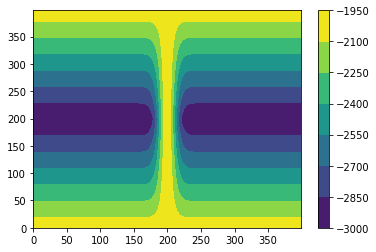

In [73]:
plt.contourf((bathy[1:,:]), vmax=-2000)
plt.colorbar()

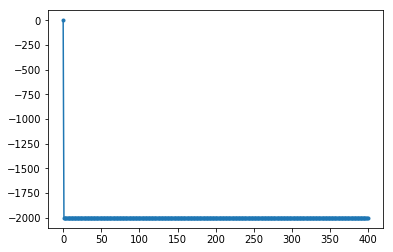

In [75]:
plt.plot((bathy[:,200]),'.-')

# Define the wind conditions

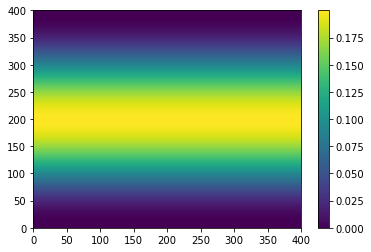

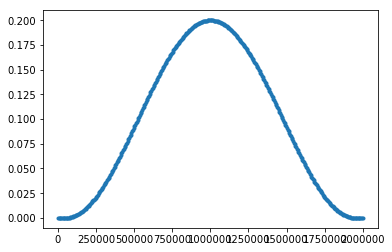

In [11]:
tau0 = 0.2

# make sure that the northern point has zero winds
tau = np.zeros([n,n])


a =100e3 # the narrowness of the 
L =2000e3
tau = tau0*(np.sin(np.pi* (yc-a/2)/(L-a))**2) # slightly squeezed wind profile to account 

tau[yc<=a/2] = 0.
tau[yc>=(L-a/2)] = 0.

tau.astype(tp).tofile((output_dir + 'TAU_sin2_with_zeros_for50km_%03d_%03d.bin'%(tau0*1e4,res)))

flag = 1
if flag ==1 :
    plt.pcolor(tau)
    plt.colorbar()

    plt.figure()
    plt.plot(yc[:,n/2],tau[:,n/2],'.')
    
    

# Define the surface restoring conditions 


In [12]:
Tmin, Tmax = 0., 8.0
Tsurf = np.tile(np.linspace(Tmin, Tmax, n), (n,1)).T

Tsurf.astype(tp).tofile((output_dir + 'THETA_surf_0to8_linear_%03d.bin' %res))

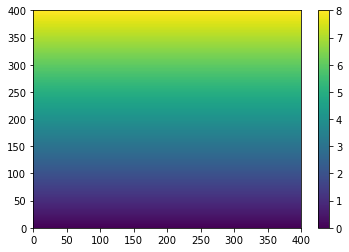

In [13]:
flag = 1
if flag == 1:
    plt.pcolor(Tsurf)
    plt.colorbar()

# Below this the code interpolates the model output to a different grid

In [8]:
delR =   np.array([1.00,    1.14,    1.30,    1.49,   1.70,  
                   1.93,    2.20,    2.50,    2.84,   3.21,        
                   3.63,    4.10,    4.61,    5.18,   5.79,   
                   6.47,    7.20,    7.98,    8.83,   9.73,  
                   10.69,   11.70,   12.76,   13.87,  15.03,   
                   16.22,   17.45,   18.70,   19.97,  21.27,    
                   22.56,   23.87,   25.17,   26.46,  27.74,  
                   29.00,   30.24,   31.45,   32.65,  33.82, 
                   34.97,   36.09,   37.20,   38.29,  39.37,   
                   40.45,   41.53,   42.62,   43.73,  44.87,
                   46.05,   47.28,   48.56,   49.93,  51.38,
                   52.93,   54.61,   56.42,   58.38,  60.53,
                   62.87,   65.43,   68.24,   71.33,  74.73,
                   78.47,   82.61,   87.17,   92.21,  97.79,
                   103.96,  110.79,  118.35,  126.73, 136.01, 174.67])

In [9]:
Z = -(delR.cumsum())

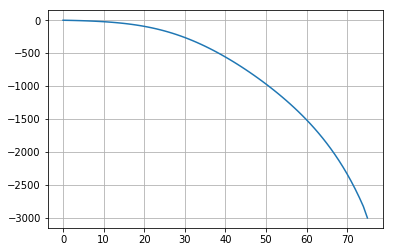

In [10]:
plt.plot(Z)
plt.grid('on')

In [6]:
spinup2_dir = '/swot/SUM05/dbalwada/channel_beta/20km/run_spinup_2/'
ds_20 = open_mdsdataset(spinup2_dir, iters = [5184000],delta_t=1200, prefix=['T']
                     ,ignore_unknown_vars=True, geometry='cartesian')


/home/dbalwada/python_libs/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


In [11]:
spinup_small_lam_dir = '/swot/SUM05/dbalwada/channel_beta/20km/run_spinup_small_lam/'
ds_20_small_lam = open_mdsdataset(spinup_small_lam_dir, iters = [5184000],delta_t=1200, prefix=['T']
                     ,ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/python_libs/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


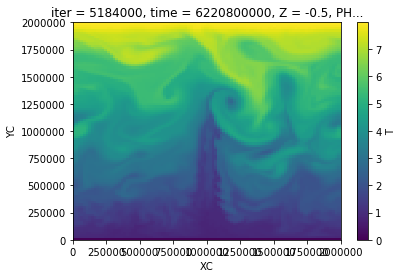

In [12]:
ds_20_small_lam['T'].isel(Z=0).plot()

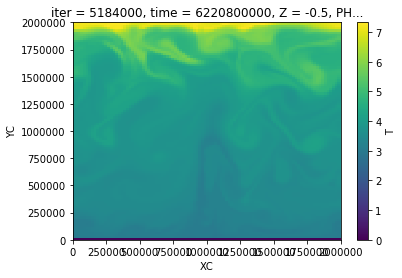

In [7]:
ds_20['T'].isel(Z=0).plot()

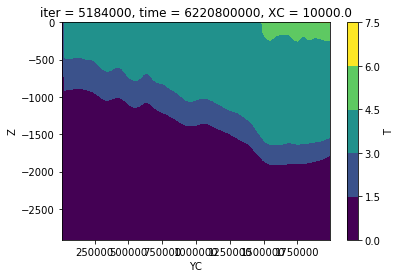

In [8]:
ds_20['T'].isel(XC=0,time=0).plot.contourf()

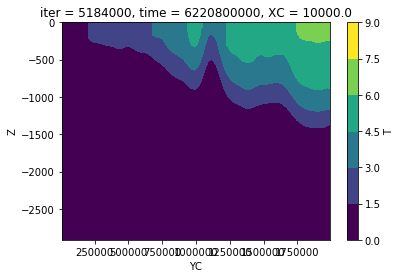

In [13]:
ds_20_small_lam['T'].isel(XC=0,time=0).plot.contourf()

In [9]:
ds20_reshaped = ds_20['T'].isel(time=-1).values


In [14]:
ds20_small_lam_reshaped = ds_20_small_lam['T'].isel(time=-1).values


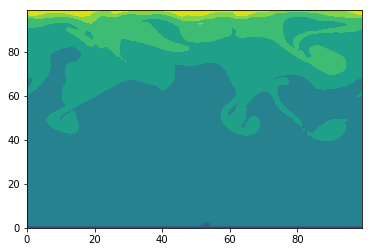

In [10]:
plt.contourf(ds20_reshaped[0,:,:])

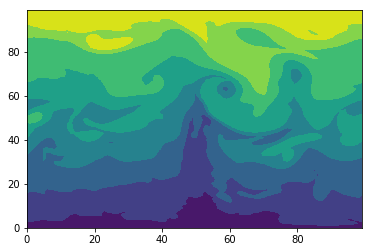

In [15]:
plt.contourf(ds20_small_lam_reshaped[0,:,:])

In [16]:
xn, yn = xc, yc       # new grid
xo, yo = np.meshgrid(ds_20_small_lam.XC.values, ds_20_small_lam.YC.values) # old grid

In [17]:
xn[-1,-1], xo[-1,-1]

(1997500.0, 1990000.0)

In [18]:
# create an extended matrix
# add extra points to both side of the domain that 
# sit at the farthest edge

xtemp = xo[0,:]
xtemp2 = np.zeros([len(xtemp)+2])
xtemp2[1:(len(xtemp2)-1)] = xtemp
xtemp2[-1] = Lx


ytemp = yo[:,0]
ytemp2 = np.zeros([len(ytemp)+2])
ytemp2[1:(len(ytemp2)-1)] = ytemp
ytemp2[-1]=Lx

xo2, yo2 = np.meshgrid(xtemp2, ytemp2)

In [20]:
hydro_reshaped_pad = np.zeros([76, len(ytemp)+2, len(xtemp)+2])

hydro_reshaped_pad[:,1:len(ytemp)+1,1:len(xtemp)+1] = ds20_small_lam_reshaped

hydro_reshaped_pad[:,:,0] = hydro_reshaped_pad[:,:,1]
hydro_reshaped_pad[:,:,-1] = hydro_reshaped_pad[:,:,1]
hydro_reshaped_pad[:,0,:] = hydro_reshaped_pad[:,1,:]
hydro_reshaped_pad[:,-1,:] = hydro_reshaped_pad[:,-3,:]
hydro_reshaped_pad[:,-2,:] = hydro_reshaped_pad[:,-3,:]

In [21]:
hydro_reshaped_pad.shape

(76, 102, 102)

In [22]:
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
new_temp = np.zeros((76,len(yn[:,0]),len(xn[0,:])))

In [23]:
for klev in range(0, 76):
    
    data = hydro_reshaped_pad[klev,:,:]

    points = np.vstack((yo2.ravel(), xo2.ravel())).T
    values = data.ravel()
    lint = LinearNDInterpolator(points, values)

    new_points = np.vstack((yn.ravel(), xn.ravel())).T

    new_values = lint(new_points)
    
    new_temp[klev,:,:] = new_values.reshape(xn.shape)
    print(klev)

    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75


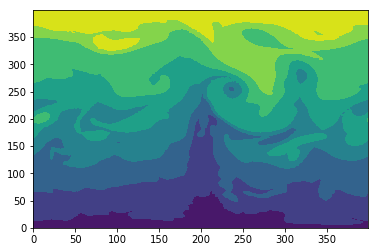

In [24]:
plt.contourf(new_temp[0,:,:])

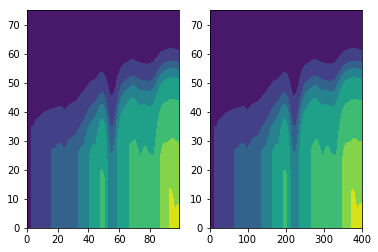

In [26]:
plt.subplot(121)
plt.contourf(ds20_small_lam_reshaped[:,:,0])
plt.subplot(122)
plt.contourf(new_temp[:,:,0] )

In [27]:
new_temp.shape

(76, 400, 400)

In [28]:
new_temp=new_temp+0.001

In [29]:
new_temp.astype(tp).tofile(output_dir + 'THETA_init_20km_small_lam_start_%03d.bin' % res)

In [122]:
print f[theta==-35], beta[theta==-35]

[ -8.34233111e-05] [  1.86796750e-11]


In [129]:
f[theta==-50.]/f[theta==-35]*7.5

array([ 10.01668297])

In [115]:
((beta[theta==-50.]/beta[theta==-35.])**0.5)*100

array([ 88.58322527])

In [27]:
1101600*40/24/3600/30

17.0

# Tracer relax files

In [20]:
rbcs_mask = np.zeros((76,n,n))
rbcs_mask[0,:,:] = 1.
rbcs_mask.astype(tp).tofile(output_dir + 'rbcs_mask_%03d.bin' % res)

rbcs_relax = np.zeros((76,n,n))
rbcs_relax[0,:,:] = 1.
rbcs_relax.astype(tp).tofile(output_dir + 'rbcs_relax_%03d.bin' % res)


In [131]:
# Just check if the 20km run started properly
data_dir = '/swot/SUM05/dbalwada/can_delete/20km/run_spinup/'
ds = open_mdsdataset(data_dir, delta_t=1200,
                     ignore_unknown_vars=True, geometry='cartesian', prefix = ['S', 'Eta', 'U', 'T', 'W', 'V'])

/home/dbalwada/python_libs/xmitgcm/xmitgcm/mds_store.py:695: UserWarning: Couldn't find available_diagnostics.log in /swot/SUM05/dbalwada/can_delete/20km/run_spinup/. Using default version.
  "in %s. Using default version." % data_dir)


In [132]:
ds


<xarray.Dataset>
Dimensions:  (XC: 100, XG: 100, YC: 100, YG: 100, Z: 76, Zl: 76, Zp1: 77, Zu: 76, time: 2)
Coordinates:
  * XC       (XC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * YC       (YC) >f4 10000.0 30000.0 50000.0 70000.0 90000.0 110000.0 ...
  * XG       (XG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * YG       (YG) >f4 0.0 20000.0 40000.0 60000.0 80000.0 100000.0 120000.0 ...
  * Zl       (Zl) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
  * Zu       (Zu) >f4 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 -16.1 ...
  * Z        (Z) >f4 -0.5 -1.57 -2.79 -4.185 -5.78 -7.595 -9.66 -12.01 ...
  * Zp1      (Zp1) >f4 0.0 -1.0 -2.14 -3.44 -4.93 -6.63 -8.56 -10.76 -13.26 ...
    dxC      (YC, XG) >f4 20000.0 20000.0 20000.0 20000.0 20000.0 20000.0 ...
    rAs      (YG, XC) >f4 4e+08 4e+08 4e+08 4e+08 4e+08 4e+08 4e+08 4e+08 ...
    rAw      (YC, XG) >f4 4e+08 4e+08 4e+08 4e+08 4e+08 4e+08 4e+08 4e+08 ...
    Depth    (YC, XC

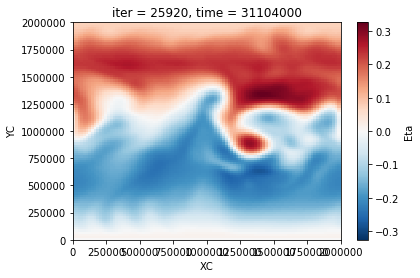

In [133]:
ds.Eta.isel(time=-1).plot()

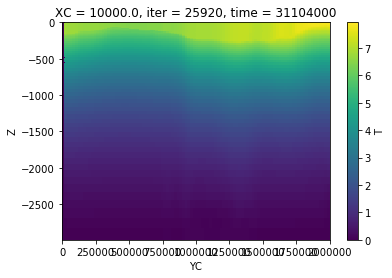

In [134]:
ds['T'].isel(time=-1,XC=0).plot()

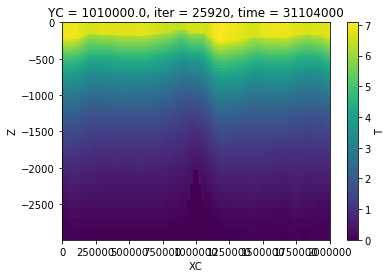

In [138]:
ds['T'].isel(time=-1,YC=50).plot()

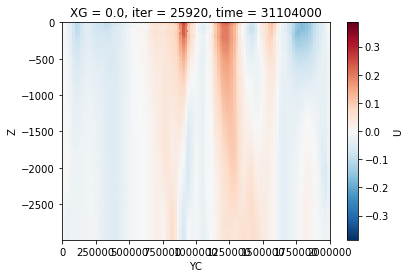

In [136]:
ds['U'].isel(time=-1,XG=0).plot()